# Загрузка данных(кода в колабе)

In [1]:
# !wget -O dataset_colors.zip "https://downloader.disk.yandex.ru/disk/c114837f72ad6cc8639c45358eda7f7fe20782d1b4c818a3affc533df5085184/67d1cce4/WYSj2tn0xwfH9xrDn6OMB8Xma9PEMVVkSdj-oTw_no6Lf3VlXmTFMBrR9uEtahv-HyUjYUqUXYJgg46saw6Mxw%3D%3D?uid=0&filename=dataset_colors.zip&disposition=attachment&hash=Xb8qDbUG6BngPcy%2B0ZCrTUCidjMJdvUIof229dcBskZkF3VkCsI1pAlXMCohgSKXq/J6bpmRyOJonT3VoXnDag%3D%3D%3A/dataset_colors.zip&limit=0&content_type=application%2Fzip&owner_uid=957907626&fsize=9820116123&hid=a728aa4ce5f261d0a30ab7a0cf8b38fb&media_type=compressed&tknv=v2"

In [2]:
# !unzip /content/dataset_colors.zip

# База

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageOps
import pdb
import os
from tqdm import tqdm
import random

import warnings
warnings.filterwarnings('ignore')

In [4]:
def set_seeds():
    SEED_VALUE = 69

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
set_seeds()

In [5]:
device='cuda'
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

# Архитектура

In [6]:
class TransformerEncoder(nn.Module):
  def __init__(self, d_model, n_heads, mlp_ratio =4):
      super().__init__()

      self.d_model = d_model
      self.n_heads = n_heads

      self.ln1 = nn.LayerNorm(d_model)

      self.mha = MultiheadAttention(d_model, n_heads)

      self.ln2 = nn.LayerNorm(d_model)

      self.mlp = nn.Sequential(
          nn.Linear(d_model, d_model*mlp_ratio),
          nn.GELU(),
          nn.Linear(d_model * mlp_ratio, d_model)
      )

  def forward(self, x, mask = None):

      x_n = self.mha(self.ln1(x), mask = mask)
      x = x + self.mlp(self.ln2(x_n))

      return x

In [7]:
class MultiheadAttention(nn.Module):
  def __init__(self, d_model, n_heads):
      super().__init__()


      self.qkv_dim = d_model //  n_heads

      self.W_o = nn.Linear(d_model,d_model)

      self.multi_head = nn.ModuleList([AttentionHead(d_model, self.qkv_dim) for _ in range(n_heads)])

  def forward(self,x,mask = None):

      out = torch.cat([head(x, mask=mask) for head in self.multi_head], dim = -1)

      out = self.W_o(out)

      return out

In [8]:
class AttentionHead(nn.Module):
  def __init__(self, d_model, qkv_dim):
      super().__init__()

      self.qkv_dim = qkv_dim

      self.query = nn.Linear(d_model, qkv_dim)
      self.key = nn.Linear(d_model, qkv_dim)
      self.value = nn.Linear(d_model, qkv_dim)

  def forward(self, x, mask = None):
      Q = self.query(x)
      K = self.key(x)
      V = self.value(x)

      attention = Q @ K.transpose(-2,-1)
      attention = attention / self.qkv_dim ** 0.5

      if mask is not None:
         mask = attention.masked_fill(mask == 0, float("-inf"))

      attention  = torch.softmax(attention, dim = -1)

      attention = attention @ V

      return attention

In [9]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        self.d_model = d_model
        self.max_seq_length = max_seq_length

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len]

In [10]:
class VisionEncoder(nn.Module):

    def __init__(self, d_model,img_size,patch_size, n_channels, n_heads,n_layers, emb_dim):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] ==0, "image dimensions should be divisible by patch dim"
        assert d_model % n_heads == 0, "d_model should be divisible by n_heads"

        self.num_patches = (img_size[0] * img_size[1] ) // (patch_size[0] * patch_size[1]) # max_seq_length

        self.max_seq_length = self.num_patches +1

        self.linear_proj = nn.Conv2d(in_channels = n_channels,out_channels = d_model, kernel_size = patch_size[0], stride = patch_size[0])

        self.cls_token = nn.Parameter(torch.randn(1,1,d_model), requires_grad = True)

        self.positional_embedding =  PositionalEmbedding(d_model, self.max_seq_length)

        self.transformer_encoder = nn.ModuleList([TransformerEncoder(d_model, n_heads) for _ in range(n_layers)])

        self.projection = nn.Parameter(torch.randn(d_model, emb_dim))

    def forward(self,x, mask = None):

        x  = self.linear_proj(x)

        x = x.flatten(2).transpose(-2, -1)


        x = torch.cat((self.cls_token.expand(x.shape[0], -1,-1), x), dim = 1)

        x =  self.positional_embedding(x)

        for encoder_layer in self.transformer_encoder:
            x = encoder_layer(x, mask)

        x = x[:, 0, :]

        if self.projection is not None:
           x  = x  @ self.projection

        x  = x  / torch.norm(x , dim = -1 , keepdim = True)


        return x

In [11]:
def tokenizer(text, encode=True, mask=None, max_seq_length=32):
    if encode:
        out = chr(2) + text + chr(3)

        if len(out) > max_seq_length:
            out = out[:max_seq_length]

        out = out + "".join([chr(0) for _ in range(max_seq_length - len(out))])

        out = torch.IntTensor(list(out.encode("utf-8")))

        mask = torch.ones(len(out.nonzero()))

        if len(mask) < max_seq_length:
            mask = torch.cat((mask, torch.zeros(max_seq_length - len(mask)))).type(torch.IntTensor)
        else:
            mask = mask.type(torch.IntTensor)
    else:
        out = [chr(x) for x in text[1:len(mask.nonzero()) - 1]]
        out = "".join(out)
        mask = None

    return out, mask


In [12]:
class TextEncoder(nn.Module):
  def __init__(self, vocab_size, d_model, max_seq_length, n_layers,n_heads, emb_dim):
      super().__init__()

      self.max_seq_length = max_seq_length

      self.embed = nn.Embedding(vocab_size, d_model)

      self.positional_embedding = PositionalEmbedding(d_model, max_seq_length)

      self.transformer_encoder = nn.ModuleList([TransformerEncoder(d_model, n_heads) for _ in range(n_layers)])

      self.projection = nn.Parameter(torch.randn(d_model, emb_dim))

  def forward(self, text, mask = None):

      x = self.embed(text)

      x = self.positional_embedding(x)

      for encoder_layer in self.transformer_encoder:
          x = encoder_layer(x, mask=mask)

      x = x[torch.arange(text.shape[0]), torch.sub(torch.sum(mask[:,0],dim=1),1)]

      if self.projection is not None:
         x = x @ self.projection

      x = x / torch.norm(x, dim=-1, keepdim = True)

      return x


In [13]:
class TextEncoder_Retrieval(nn.Module):
  def __init__(self, vocab_size, d_model, max_seq_length, n_layers,n_heads, emb_dim):
      super().__init__()

      self.max_seq_length = max_seq_length

      self.embed = nn.Embedding(vocab_size, d_model)

      self.positional_embedding = PositionalEmbedding(d_model, max_seq_length)

      self.transformer_encoder = nn.ModuleList([TransformerEncoder(d_model, n_heads) for _ in range(n_layers)])

      self.projection = nn.Parameter(torch.randn(d_model, emb_dim))


  def forward(self, text, mask=None):
        x = self.embed(text)
        x = self.positional_embedding(x)

        for encoder_layer in self.transformer_encoder:
            x = encoder_layer(x, mask=mask)

        if mask is not None:
            seq_lengths = mask.sum(dim=1) - 1
            x = x[torch.arange(text.shape[0]), seq_lengths]
        else:
            x = x[:, -1]

        if self.projection is not None:
            x = x @ self.projection

        x = x / torch.norm(x, dim=-1, keepdim=True)

        return x

In [14]:
class CLIP(nn.Module):

    def __init__(self, emb_dim, vit_layers, vit_d_model, img_size, patch_size, n_channels, vit_heads, vocab_size, max_seq_length, text_heads, text_layers, text_d_model, retrieval = False):
        super().__init__()

        self.vision_encoder = VisionEncoder(vit_d_model, img_size, patch_size, n_channels, vit_heads, vit_layers, emb_dim)
        # print(retrieval)
        if retrieval:
            self.text_encoder = TextEncoder_Retrieval(vocab_size, text_d_model, max_seq_length, text_layers, text_heads, emb_dim)
        else:
            self.text_encoder = TextEncoder(vocab_size, text_d_model, max_seq_length, text_layers, text_heads, emb_dim)

        self.temperature = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def CLIPLoss(self, logits, device = "cuda"):
        labels = torch.arange(logits.shape[0]).to(device)

        loss_v = nn.functional.cross_entropy(logits.transpose(-2,-1), labels)

        loss_t = nn.functional.cross_entropy(logits, labels)
        loss = (loss_v + loss_t) / 2

        return loss

    def forward(self, image, text, mask=None):
        V_e = self.vision_encoder(image)
        T_e = self.text_encoder(text, mask)
        # print(f"V_e shape: {V_e.shape}, T_e shape: {T_e.shape}")

        logits = (V_e @ T_e.transpose(-2, -1)) * torch.exp(self.temperature)

        loss = self.CLIPLoss(logits, self.device)

        return loss

# Датка

In [15]:
# Vision
emb_dim = 128
vit_d_model = 32
img_size = (80,80)
patch_size = (5,5)
n_channels = 3
vit_layers = 8
vit_heads = 4

# Text
vocab_size = 256
text_d_model = 64
max_seq_length = 128
text_heads = 8
text_layers = 8
lr = 3e-3
epochs = 10
batch_size = 128
target_col = 'lable'

In [71]:
df = pd.read_csv('/kaggle/input/avitohack/dataset_colors/train_data.csv')

categories_dict = {"сумки": "bags", "столы": "tables", "одежда для девочек": "clothes for girls", "стулья": "chairs"}
colors_dict = {"zelenyi": "green", "chernyi": "black", "belyi": "white", "bordovyi": "burgundy", "krasnyi": "red", "bezhevyi": "beige", "raznocvetnyi": "multicolored", "rozovyi": "pink", "serebristyi": "silver", "korichnevyi": "brown", "fioletovyi": "purple", "seryi": "gray", "goluboi": "light blue", "oranzhevyi": "orange", "sinii": "blue", "biryuzovyi": "turquoise", "zolotoi": "gold", "zheltyi": "yellow"}
colors_back = {'green': 'zelenyi', 'black': 'chernyi', 'white': 'belyi', 'burgundy': 'bordovyi', 'red': 'krasnyi', 'beige': 'bezhevyi', 'multicolored': 'raznocvetnyi', 'pink': 'rozovyi', 'silver': 'serebristyi', 'brown': 'korichnevyi', 'purple': 'fioletovyi', 'gray': 'seryi', 'light blue': 'goluboi', 'orange': 'oranzhevyi', 'blue': 'sinii', 'turquoise': 'biryuzovyi', 'gold': 'zolotoi', 'yellow': 'zheltyi'}
df['lable'] = [f'{colors_dict[i[2]]} {categories_dict[i[1]]}' for i in df.values]
df['target2'] = [f'{colors_dict[i[2]]}' for i in df.values]

unique, counts = np.unique(df[target_col].tolist(), return_counts = True)
print(f"Classes: {unique}: {counts}")

train_df, val_df = train_test_split(df, test_size=0.10, random_state=42, stratify=df['target'])

# Print the sizes of the datasets
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")
class_names = df[target_col].unique()
class_names = [str(name).lower() for name in class_names]

captions = {idx: class_name for idx, class_name in enumerate(class_names)}
captions_color = {idx: class_name.split()[0] for idx, class_name in enumerate(class_names)}

# for idx, caption in captions.items():
#     print(f"{idx}: {caption}\n")


Classes: ['beige bags' 'beige chairs' 'beige clothes for girls' 'beige tables'
 'black bags' 'black chairs' 'black clothes for girls' 'black tables'
 'blue bags' 'blue chairs' 'blue clothes for girls' 'blue tables'
 'brown bags' 'brown chairs' 'brown clothes for girls' 'brown tables'
 'burgundy bags' 'burgundy chairs' 'burgundy clothes for girls'
 'burgundy tables' 'gold bags' 'gold chairs' 'gold clothes for girls'
 'gold tables' 'gray bags' 'gray chairs' 'gray clothes for girls'
 'gray tables' 'green bags' 'green chairs' 'green clothes for girls'
 'green tables' 'light blue bags' 'light blue chairs'
 'light blue clothes for girls' 'light blue tables' 'multicolored bags'
 'multicolored chairs' 'multicolored clothes for girls'
 'multicolored tables' 'orange bags' 'orange chairs'
 'orange clothes for girls' 'orange tables' 'pink bags' 'pink chairs'
 'pink clothes for girls' 'pink tables' 'purple bags' 'purple chairs'
 'purple clothes for girls' 'purple tables' 'red bags' 'red chairs'
 'r

In [51]:
captions_color

{0: 'green',
 1: 'black',
 2: 'white',
 3: 'white',
 4: 'burgundy',
 5: 'green',
 6: 'red',
 7: 'beige',
 8: 'multicolored',
 9: 'pink',
 10: 'green',
 11: 'silver',
 12: 'brown',
 13: 'purple',
 14: 'beige',
 15: 'white',
 16: 'burgundy',
 17: 'pink',
 18: 'pink',
 19: 'brown',
 20: 'black',
 21: 'black',
 22: 'multicolored',
 23: 'beige',
 24: 'gray',
 25: 'gray',
 26: 'brown',
 27: 'light',
 28: 'pink',
 29: 'beige',
 30: 'multicolored',
 31: 'multicolored',
 32: 'white',
 33: 'orange',
 34: 'blue',
 35: 'turquoise',
 36: 'gold',
 37: 'light',
 38: 'silver',
 39: 'purple',
 40: 'green',
 41: 'yellow',
 42: 'orange',
 43: 'red',
 44: 'light',
 45: 'red',
 46: 'burgundy',
 47: 'turquoise',
 48: 'yellow',
 49: 'silver',
 50: 'burgundy',
 51: 'gold',
 52: 'purple',
 53: 'blue',
 54: 'black',
 55: 'blue',
 56: 'blue',
 57: 'gray',
 58: 'gray',
 59: 'red',
 60: 'light',
 61: 'orange',
 62: 'purple',
 63: 'brown',
 64: 'yellow',
 65: 'gold',
 66: 'orange',
 67: 'yellow',
 68: 'silver',
 69

In [ ]:
class MyntraDataset(Dataset):
    def __init__(self, data_frame, captions, captions_color, target_size=28):

        self.data_frame = data_frame
        self.target_size = target_size  # Desired size for the square image
        self.transform = T.Compose([
            T.ToTensor()  # Convert image to tensor
        ])

        self.captions = captions

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # while True:
          sample = self.data_frame.iloc[idx]
          img_path = os.path.join("/kaggle/input/avitohack/dataset_colors/train_data", f"{sample['id']}.jpg")
          # print()
          # print(sample['id'], img_path)
          image = Image.open(img_path).convert('RGB')

          # Resize the image to maintain aspect ratio
          image = self.resize_and_pad(image, self.target_size)

          # Apply transformations (convert to tensor)
          image = self.transform(image)

          # Retrieve the subCategory label and its corresponding caption
          label = sample[target_col].lower()

          label_idx = next(idx for idx, class_name in self.captions.items() if class_name == label)

          # # Tokenize the caption using the tokenizer function
          cap, mask = tokenizer(self.captions[label_idx])

          # Make sure the mask is a tensor
          mask = torch.tensor(mask)

          # If the mask is a single dimension, make sure it is expanded correctly
          if len(mask.size()) == 1:
              mask = mask.unsqueeze(0)

          return {"image": image, "caption": cap, "mask": mask,"id": img_path, 'color': sample['target']}

    def resize_and_pad(self, image, target_size):
        original_width, original_height = image.size
        aspect_ratio = original_width / original_height

        if aspect_ratio > 1:
            new_width = target_size
            new_height = int(target_size / aspect_ratio)
        else:
            new_height = target_size
            new_width = int(target_size * aspect_ratio)

        image = image.resize((new_width, new_height))

        pad_width = (target_size - new_width) // 2
        pad_height = (target_size - new_height) // 2

        padding = (pad_width, pad_height, target_size - new_width - pad_width, target_size - new_height - pad_height)
        image = ImageOps.expand(image, padding, fill=(0, 0, 0))

        return image

#Create datasets
train_dataset = MyntraDataset(data_frame=train_df ,captions = captions, captions_color=captions_color, target_size =80)
val_dataset = MyntraDataset(data_frame=val_df ,captions = captions, captions_color=captions_color, target_size =80)
test_dataset = MyntraDataset(data_frame=df, captions = captions, captions_color=captions_color, target_size = 80)


print("Number of Samples in Train Dataset:", len(train_dataset))
print("Number of Samples in Validation Dataset:", len(val_dataset))
print("Number of Samples in Validation Dataset:", len(test_dataset))


train_loader = DataLoader(train_dataset, shuffle = True, batch_size = batch_size,num_workers = 5)
val_loader  = DataLoader(val_dataset, shuffle = False, batch_size = batch_size,num_workers = 5)
test_loader = DataLoader(test_dataset, shuffle = False, batch_size = batch_size, num_workers = 5)
print(0)
#Sanity check of dataloader initialization
# len(next(iter(train_loader)))  #(img_tensor,label_tensor)

In [ ]:
test_loader

In [ ]:
def visualize_samples(dataset, tokenizer, num_samples=5):
    for i in range(num_samples):
        sample = dataset[i]  # Access the ith sample in the dataset
        image = sample['image']
        tokenized_caption = sample['caption']
        mask = sample['mask'][0]

        original_caption = tokenizer(tokenized_caption, encode=False, mask=mask)[0]

        image = T.ToPILImage()(image)

        plt.figure(figsize=(4, 4))
        plt.imshow(image,cmap="gray")
        plt.title(f"Class: {original_caption}") 
        plt.axis('off')
        plt.show()

visualize_samples(train_dataset, tokenizer, num_samples=5)

In [19]:
from torch.optim.lr_scheduler import ReduceLROnPlateau



print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")


model = CLIP(emb_dim, vit_layers, vit_d_model, img_size,patch_size,n_channels, vit_heads, vocab_size, max_seq_length, text_heads, text_layers,text_d_model, retrieval = False).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr, amsgrad=True)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True, threshold=0.15)

Using device:  cuda (Tesla P100-PCIE-16GB)


In [20]:
total_params = 0

total_params = sum([ param.numel() for param in model.parameters() if param.requires_grad])

print(f"Total number of trainable parameters: {total_params}; i.e., {total_params/100000:.2f} M")

Total number of trainable parameters: 532641; i.e., 5.33 M


In [21]:
best_loss = np.inf
for epoch in range(epochs):
    epoch_loss = 0.0  # To accumulate the loss over the epoch
    with tqdm(enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch [{epoch+1}/{epochs}]") as tepoch:
        for i, data in tepoch:
            img, cap, mask = data["image"].to(device), data["caption"].to(device), data["mask"].to(device)
            optimizer.zero_grad()
            loss = model(img, cap, mask)
            loss.backward()
            optimizer.step()

            # Update the progress bar with the current loss
            tepoch.set_postfix(loss=loss.item())
            epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.3f}")

    # scheduler.step(avg_loss)
    # print(f"Learning rate after epoch {epoch + 1}: {scheduler.get_last_lr()[0]}")

    # Save model if it performed better than the previous best
    if avg_loss <= best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "clip.pt")
        print("Model Saved.")

Epoch [1/10]: 100%|██████████| 235/235 [06:15<00:00,  1.60s/it, loss=3]   

Epoch [1/10], Average Loss: 4.848
Model Saved.



Epoch [2/10]: 100%|██████████| 235/235 [05:55<00:00,  1.51s/it, loss=2.47]

Epoch [2/10], Average Loss: 4.663
Model Saved.



Epoch [3/10]: 100%|██████████| 235/235 [05:54<00:00,  1.51s/it, loss=2.5] 

Epoch [3/10], Average Loss: 4.366
Model Saved.



Epoch [4/10]: 100%|██████████| 235/235 [05:53<00:00,  1.51s/it, loss=2.45]

Epoch [4/10], Average Loss: 4.077
Model Saved.



Epoch [5/10]: 100%|██████████| 235/235 [05:55<00:00,  1.51s/it, loss=2.24]

Epoch [5/10], Average Loss: 3.933
Model Saved.



Epoch [6/10]: 100%|██████████| 235/235 [05:55<00:00,  1.51s/it, loss=2.09]

Epoch [6/10], Average Loss: 3.833
Model Saved.



Epoch [7/10]: 100%|██████████| 235/235 [05:57<00:00,  1.52s/it, loss=2.08]

Epoch [7/10], Average Loss: 3.763
Model Saved.



Epoch [8/10]: 100%|██████████| 235/235 [05:52<00:00,  1.50s/it, loss=2.18]

Epoch [8/10], Average Loss: 3.715
Model Saved.



Epoch [9/10]: 100%|██████████| 235/235 [05:54<00:00,  1.51s/it, loss=2.1] 


Epoch [9/10], Average Loss: 3.675
Model Saved.


Epoch [10/10]: 100%|██████████| 235/235 [05:52<00:00,  1.50s/it, loss=2.09]

Epoch [10/10], Average Loss: 3.625
Model Saved.


In [26]:
model = CLIP(emb_dim, vit_layers, vit_d_model, img_size,patch_size,n_channels, vit_heads, vocab_size, max_seq_length, text_heads, text_layers,text_d_model,retrieval = False).to(device)

model.load_state_dict(torch.load("clip.pt", map_location=device))

text = torch.stack([tokenizer(x)[0] for x in val_dataset.captions.values()]).to(device)

mask = torch.stack([tokenizer(x)[1] for x in val_dataset.captions.values()])
mask = mask.repeat(1,len(mask[0])).reshape(len(mask),len(mask[0]),len(mask[0])).to(device)

In [86]:
colors_counter = {'green': 0, 'black': 0, 'white': 0, 'burgundy': 0, 'red': 0, 'beige': 0, 'multicolored': 0, 'pink': 0, 'silver': 0, 'brown': 0, 'purple': 0, 'gray': 0, 'lightblue': 0, 'orange': 0, 'blue': 0, 'turquoise': 0, 'gold': 0, 'yellow': 0}

correct, correct_color, total = 0,0,0
with torch.no_grad():
    for data in val_loader:
        
        images, labels, colors = data["image"].to(device), data["caption"].to(device), np.array(data['color'])
        image_features = model.vision_encoder(images)
        text_features = model.text_encoder(text, mask=mask)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        _, indices = torch.max(similarity,1)
   
        pred = torch.stack([tokenizer(val_dataset.captions[int(i)])[0] for i in indices]).to(device)
        correct += int(sum(torch.sum((pred==labels),dim=1)//len(pred[0])))

        
        print(tokenizer(labels[i], encode=False, mask=mask))
        print(val_dataset.captions[0])
        break
        # correct_color += sum([tokenizer(labels[i], encode=False, mask=mask)[0].split()[0]==colors_dict[colors[i]] for i in range(len(labels))])
        
        total += len(labels)

print(f'\nModel Accuracy(object+color): {100 * correct / total}%', 
      # f'\nModel Accuracy(color): {100 * correct_color / total} %'
)

('black bags\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', None)
green bags


ZeroDivisionError: division by zero

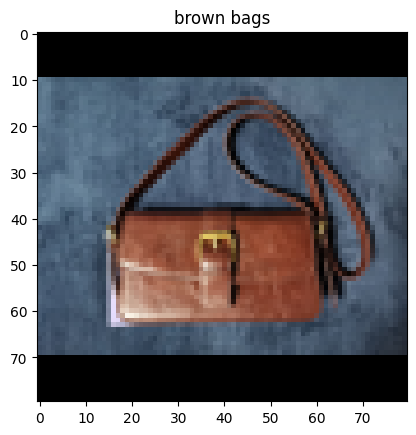


Top predictions:

     orange bags: 99.98%
orange clothes for girls: 0.02%
   orange chairs: 0.00%
      red chairs: 0.00%
multicolored bags: 0.00%


In [88]:
class_names = df[target_col].unique()
class_names = [str(name) for name in class_names]

text = torch.stack([tokenizer(x)[0] for x in class_names]).to(device)
mask = torch.stack([tokenizer(x)[1] for x in class_names])
mask = mask.repeat(1,len(mask[0])).reshape(len(mask),len(mask[0]),len(mask[0])).to(device)

idx = 10


img = val_dataset[idx]["image"][None,:]
plt.imshow(img[0].permute(1, 2, 0)  ,cmap="gray")
plt.title(tokenizer(val_dataset[idx]["caption"], encode=False, mask=val_dataset[idx]["mask"][0])[0])
plt.show()
img = img.to(device)
with torch.no_grad():
  image_features = model.vision_encoder(img)
  text_features = model.text_encoder(text, mask=mask)


image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{class_names[int(index)]:>16s}: {100 * value.item():.2f}%")

In [ ]:
retrieval_model = CLIP(emb_dim, vit_layers, vit_d_model, img_size,patch_size,n_channels, vit_heads, vocab_size, max_seq_length, text_heads, text_layers,text_d_model, retrieval = True).to(device)

retrieval_model.load_state_dict(torch.load("clip.pt", map_location=device))


query = "bags"
query_text, query_mask = tokenizer(query)
query_text = query_text.unsqueeze(0).to(device)  # Add batch dimension
query_mask = query_mask.unsqueeze(0).to(device)

with torch.no_grad():
    query_features = retrieval_model.text_encoder(query_text, mask=query_mask)
    query_features /= query_features.norm(dim=-1, keepdim=True)

image_features_list = []
image_paths = []

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=5)

with torch.no_grad():
    for batch in val_loader:
        # print(batch)
        images = batch["image"].to(device)
        features = retrieval_model.vision_encoder(images)
        features /= features.norm(dim=-1, keepdim=True)

        image_features_list.append(features)
        image_paths.extend(batch["id"])  # Assuming batch contains image paths or IDs

image_features = torch.cat(image_features_list, dim=0)

similarities = (query_features @ image_features.T) * torch.exp(model.temperature)

similarities = similarities.softmax(dim=-1)

top_values, top_indices = similarities.topk(20)

print(f"\nTop 5 images for query '{query}':\n")
for value, index in zip(top_values[0], top_indices[0]):
    print(f"Similarity: {100 * value.item():.2f}%")
    img_path = image_paths[index]

    img = Image.open(img_path).convert("RGB")
    plt.imshow(img)
    plt.title(f"Similarity: {100 * value.item():.2f}%")
    plt.axis('off')
    plt.show()
